# Word2Vec Gender Bias Analysis

This notebook analyzes gender bias in Word2Vec embeddings using:
1. **Intrinsic Bias**: WEAT (Word Embedding Association Test) for gender-career stereotypes


## Research Questions:
- Do Word2Vec embeddings associate male names more with career words?

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import spatial, stats
from gensim.models import Word2Vec
import gensim.downloader as api
from sklearn.metrics import accuracy_score, f1_score
from datasets import load_dataset
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('default')
sns.set_palette("husl")

In [3]:
# Global variables for the analysis
MODEL = None  # Will store our Word2Vec model
WEAT_WORDLISTS = {
    'gender_career': {
        # MALE NAMES (20 names instead of 8)
        'target_1': [
            'james', 'john', 'robert', 'michael', 'william', 'david', 'richard', 'joseph',
            'thomas', 'christopher', 'charles', 'daniel', 'matthew', 'anthony', 'mark', 'donald',
            'steven', 'paul', 'andrew', 'joshua'
        ],
        
        # FEMALE NAMES (20 names instead of 8) 
        'target_2': [
            'mary', 'patricia', 'jennifer', 'linda', 'elizabeth', 'barbara', 'susan', 'jessica',
            'sarah', 'karen', 'nancy', 'lisa', 'betty', 'helen', 'sandra', 'donna',
            'carol', 'ruth', 'sharon', 'michelle'
        ],
        
        # CAREER WORDS (15 words instead of 6)
        'attribute_1': [
            'career', 'corporation', 'salary', 'office', 'business', 'professional',
            'executive', 'management', 'leadership', 'entrepreneur', 'workplace', 'industry',
            'employment', 'promotion', 'achievement'
        ],
        
        # FAMILY WORDS (15 words instead of 6)
        'attribute_2': [
            'home', 'family', 'children', 'parents', 'marriage', 'wedding',
            'domestic', 'household', 'nurturing', 'caring', 'relatives', 'siblings',
            'motherhood', 'parenting', 'kinship'
        ]
    }
}

In [4]:
def load_word2vec_model(model_name='word2vec-google-news-300'):
    """
    Load pre-trained Word2Vec model from Gensim
    
    Args:
        model_name (str): Name of the pre-trained model
    
    Returns:
        Loaded Word2Vec model
    """
    global MODEL
    
    try:
        print(f"Loading pre-trained model: {model_name}")
        print("This may take a few minutes for first-time download...")
        MODEL = api.load(model_name)
        print(f"Successfully loaded {model_name}!")
        print(f"Vocabulary size: {len(MODEL.key_to_index):,} words")
        return MODEL
    except Exception as e:
        print(f"Error loading model: {e}")
        return None

# Load the model
model = load_word2vec_model()

Loading pre-trained model: word2vec-google-news-300
This may take a few minutes for first-time download...
Successfully loaded word2vec-google-news-300!
Vocabulary size: 3,000,000 words


In [5]:
def get_embedding(word, model=None):
    """Get word embedding from the model"""
    if model is None:
        model = MODEL
    
    try:
        if hasattr(model, 'wv'):
            return model.wv[word]
        else:
            return model[word]
    except KeyError:
        return None

def cosine_similarity(vec1, vec2):
    """Calculate cosine similarity between two vectors"""
    return 1 - spatial.distance.cosine(vec1, vec2)

def explore_embeddings():
    """Explore basic properties of embeddings"""
    print("🔍 EMBEDDING EXPLORATION")
    print("=" * 40)
    
    # Test some words
    test_words = ['man', 'woman', 'career', 'family', 'john', 'mary']
    available_words = []
    
    for word in test_words:
        embedding = get_embedding(word)
        if embedding is not None:
            available_words.append(word)
            print(f"✅ '{word}': shape {embedding.shape}")
        else:
            print(f"❌ '{word}': not found in vocabulary")
    
    print(f"\nAvailable words for analysis: {available_words}")
    
    # Show some similarities
    if len(available_words) >= 4:
        print(f"\n📊 Sample similarities:")
        word_pairs = [('man', 'career'), ('woman', 'family'), ('man', 'family'), ('woman', 'career')]
        
        for w1, w2 in word_pairs:
            emb1, emb2 = get_embedding(w1), get_embedding(w2)
            if emb1 is not None and emb2 is not None:
                sim = cosine_similarity(emb1, emb2)
                print(f"  {w1} ↔ {w2}: {sim:.3f}")

# Run exploration
explore_embeddings()

🔍 EMBEDDING EXPLORATION
✅ 'man': shape (300,)
✅ 'woman': shape (300,)
✅ 'career': shape (300,)
✅ 'family': shape (300,)
✅ 'john': shape (300,)
✅ 'mary': shape (300,)

Available words for analysis: ['man', 'woman', 'career', 'family', 'john', 'mary']

📊 Sample similarities:
  man ↔ career: 0.152
  woman ↔ family: 0.264
  man ↔ family: 0.212
  woman ↔ career: 0.090


In [6]:
def weat_test_with_stats(target_1, target_2, attribute_1, attribute_2):
    """
    Perform WEAT test with detailed statistics for bias proof
    
    Args:
        target_1: List of target words (e.g., male names)
        target_2: List of target words (e.g., female names)  
        attribute_1: List of attribute words (e.g., career words)
        attribute_2: List of attribute words (e.g., family words)
    
    Returns:
        Dictionary with effect size, p-value, and detailed statistics
    """
    def get_similarities(targets, attributes):
        similarities = []
        target_attr_pairs = []
        
        for target in targets:
            target_vec = get_embedding(target)
            if target_vec is None:
                continue
                
            for attr in attributes:
                attr_vec = get_embedding(attr)
                if attr_vec is not None:
                    sim = cosine_similarity(target_vec, attr_vec)
                    similarities.append(sim)
                    target_attr_pairs.append((target, attr, sim))
        
        return similarities, target_attr_pairs
    
    # Calculate all similarities
    print("🧮 Calculating similarities...")
    s1_sims, s1_pairs = get_similarities(target_1, attribute_1)  # Male + Career
    s2_sims, s2_pairs = get_similarities(target_1, attribute_2)  # Male + Family  
    s3_sims, s3_pairs = get_similarities(target_2, attribute_1)  # Female + Career
    s4_sims, s4_pairs = get_similarities(target_2, attribute_2)  # Female + Family
    
    # Calculate means
    s1_mean = np.mean(s1_sims) if s1_sims else 0
    s2_mean = np.mean(s2_sims) if s2_sims else 0
    s3_mean = np.mean(s3_sims) if s3_sims else 0
    s4_mean = np.mean(s4_sims) if s4_sims else 0
    
    # WEAT effect size
    effect_size = (s1_mean - s2_mean) - (s3_mean - s4_mean)
    
    # Statistical significance test
    all_target1_diffs = [s1 - s2 for s1, s2 in zip(s1_sims[:len(s2_sims)], s2_sims[:len(s1_sims)])]
    all_target2_diffs = [s3 - s4 for s3, s4 in zip(s3_sims[:len(s4_sims)], s4_sims[:len(s3_sims)])]
    
    if all_target1_diffs and all_target2_diffs:
        t_stat, p_value = stats.ttest_ind(all_target1_diffs, all_target2_diffs)
    else:
        t_stat, p_value = 0, 1.0
    
    return {
        'effect_size': effect_size,
        'p_value': p_value,
        't_statistic': t_stat,
        'similarities': {
            'male_career': s1_sims,
            'male_family': s2_sims, 
            'female_career': s3_sims,
            'female_family': s4_sims
        },
        'means': {
            'male_career': s1_mean,
            'male_family': s2_mean,
            'female_career': s3_mean, 
            'female_family': s4_mean
        },
        'sample_sizes': {
            'male_career': len(s1_sims),
            'male_family': len(s2_sims),
            'female_career': len(s3_sims),
            'female_family': len(s4_sims)
        }
    }

def run_weat_analysis():
    """Run WEAT analysis on gender-career associations"""
    print("🎯 WEAT ANALYSIS: Gender-Career Stereotypes")
    print("=" * 50)
    
    wordlists = WEAT_WORDLISTS['gender_career']
    
    print("📝 Test Setup:")
    print(f"  Male names: {wordlists['target_1']}")
    print(f"  Female names: {wordlists['target_2']}")
    print(f"  Career words: {wordlists['attribute_1']}")
    print(f"  Family words: {wordlists['attribute_2']}")
    print()
    
    # Run WEAT test
    results = weat_test_with_stats(
        wordlists['target_1'], wordlists['target_2'],
        wordlists['attribute_1'], wordlists['attribute_2']
    )
    
    # Display results
    effect_size = results['effect_size']
    p_value = results['p_value']
    
    print("📊 RESULTS:")
    print(f"  Effect Size: {effect_size:.4f}")
    print(f"  P-value: {p_value:.4f}")
    
    # Interpretation
    significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
    bias_level = "Large" if abs(effect_size) > 0.8 else "Medium" if abs(effect_size) > 0.5 else "Small" if abs(effect_size) > 0.2 else "Minimal"
    
    print(f"  Significance: {significance}")
    print(f"  Bias Level: {bias_level}")
    
    print(f"\n💡 INTERPRETATION:")
    if effect_size > 0:
        print(f"  Male names are more associated with career words than female names")
        print(f"  This suggests gender-career stereotypes in the embeddings")
    else:
        print(f"  Female names are more associated with career words than male names")
        print(f"  This suggests reverse stereotyping or balanced associations")
    
    # Show detailed means
    print(f"\n📈 Association Strengths:")
    means = results['means']
    for category, mean_val in means.items():
        print(f"  {category.replace('_', ' ').title()}: {mean_val:.4f}")
    
    return results

# Run WEAT analysis
weat_results = run_weat_analysis()

🎯 WEAT ANALYSIS: Gender-Career Stereotypes
📝 Test Setup:
  Male names: ['james', 'john', 'robert', 'michael', 'william', 'david', 'richard', 'joseph', 'thomas', 'christopher', 'charles', 'daniel', 'matthew', 'anthony', 'mark', 'donald', 'steven', 'paul', 'andrew', 'joshua']
  Female names: ['mary', 'patricia', 'jennifer', 'linda', 'elizabeth', 'barbara', 'susan', 'jessica', 'sarah', 'karen', 'nancy', 'lisa', 'betty', 'helen', 'sandra', 'donna', 'carol', 'ruth', 'sharon', 'michelle']
  Career words: ['career', 'corporation', 'salary', 'office', 'business', 'professional', 'executive', 'management', 'leadership', 'entrepreneur', 'workplace', 'industry', 'employment', 'promotion', 'achievement']
  Family words: ['home', 'family', 'children', 'parents', 'marriage', 'wedding', 'domestic', 'household', 'nurturing', 'caring', 'relatives', 'siblings', 'motherhood', 'parenting', 'kinship']

🧮 Calculating similarities...
📊 RESULTS:
  Effect Size: 0.0564
  P-value: 0.0000
  Significance: ***
  Bi

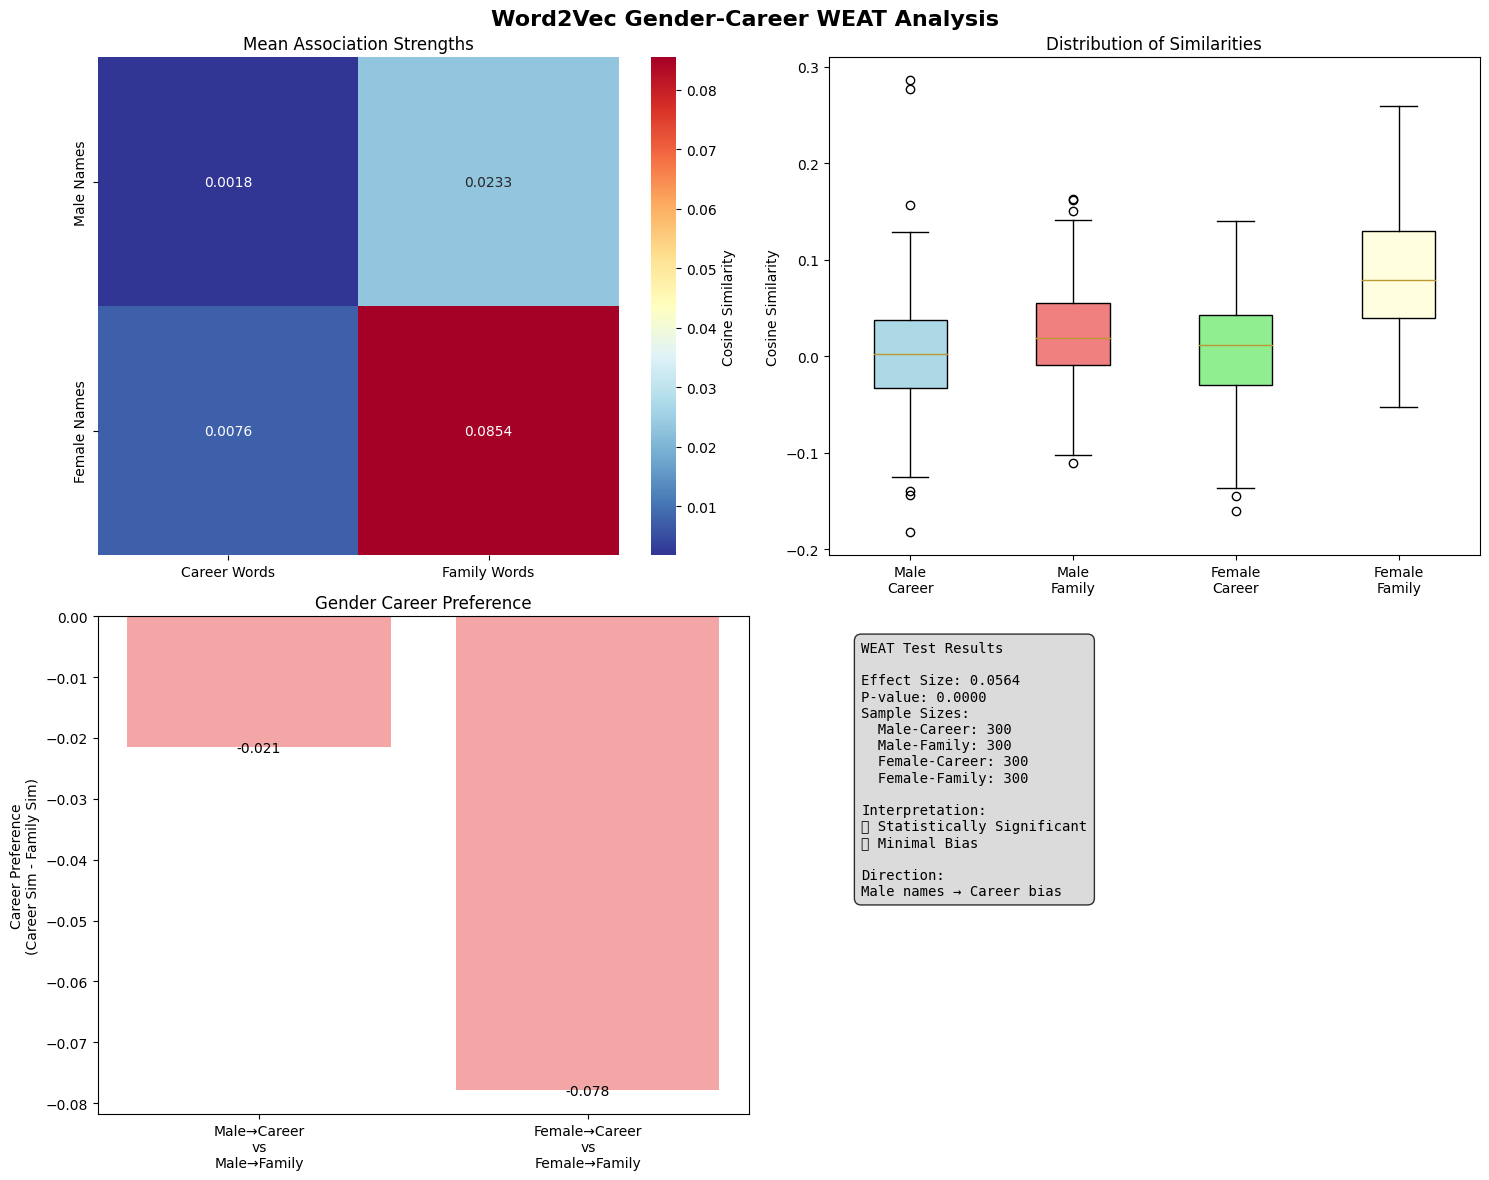

📁 Visualization saved as 'weat_gender_career_analysis.png'


In [7]:
# %% [markdown]
# ## Step 4: Visualize WEAT Results

# %%
def create_weat_visualizations(weat_results):
    """Create comprehensive visualizations for WEAT results"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Word2Vec Gender-Career WEAT Analysis', fontsize=16, fontweight='bold')
    
    # 1. Heatmap of mean associations
    if 'means' in weat_results:
        means = weat_results['means']
        heatmap_data = np.array([
            [means['male_career'], means['male_family']],
            [means['female_career'], means['female_family']]
        ])
        
        sns.heatmap(heatmap_data, 
                   xticklabels=['Career Words', 'Family Words'],
                   yticklabels=['Male Names', 'Female Names'],
                   annot=True, fmt='.4f', cmap='RdYlBu_r',
                   ax=axes[0,0], cbar_kws={'label': 'Cosine Similarity'})
        axes[0,0].set_title('Mean Association Strengths')
    
    # 2. Box plot of similarity distributions
    if 'similarities' in weat_results:
        sims = weat_results['similarities']
        data_to_plot = []
        labels = []
        
        for key, values in sims.items():
            if values:
                data_to_plot.append(values)
                labels.append(key.replace('_', '\n').title())
        
        if data_to_plot:
            box_plot = axes[0,1].boxplot(data_to_plot, labels=labels, patch_artist=True)
            colors = ['lightblue', 'lightcoral', 'lightgreen', 'lightyellow']
            for patch, color in zip(box_plot['boxes'], colors[:len(box_plot['boxes'])]):
                patch.set_facecolor(color)
            
            axes[0,1].set_ylabel('Cosine Similarity')
            axes[0,1].set_title('Distribution of Similarities')
            axes[0,1].tick_params(axis='x', rotation=0)
    
    # 3. Effect size visualization
    effect_size = weat_results['effect_size']
    p_value = weat_results['p_value']
    
    # Bar chart showing the effect
    categories = ['Male→Career\nvs\nMale→Family', 'Female→Career\nvs\nFemale→Family']
    if 'means' in weat_results:
        means = weat_results['means']
        values = [
            means['male_career'] - means['male_family'],
            means['female_career'] - means['female_family']
        ]
        
        colors = ['lightblue' if v > 0 else 'lightcoral' for v in values]
        bars = axes[1,0].bar(categories, values, color=colors, alpha=0.7)
        axes[1,0].set_ylabel('Career Preference\n(Career Sim - Family Sim)')
        axes[1,0].set_title('Gender Career Preference')
        axes[1,0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
        
        # Add value labels
        for bar, val in zip(bars, values):
            height = bar.get_height()
            axes[1,0].text(bar.get_x() + bar.get_width()/2, height + 0.001,
                          f'{val:.3f}', ha='center', va='bottom' if height > 0 else 'top')
    
    # 4. Statistical summary
    summary_text = f"""
WEAT Test Results

Effect Size: {effect_size:.4f}
P-value: {p_value:.4f}
Sample Sizes:
  Male-Career: {weat_results.get('sample_sizes', {}).get('male_career', 0)}
  Male-Family: {weat_results.get('sample_sizes', {}).get('male_family', 0)}
  Female-Career: {weat_results.get('sample_sizes', {}).get('female_career', 0)}
  Female-Family: {weat_results.get('sample_sizes', {}).get('female_family', 0)}

Interpretation:
{"✅ Statistically Significant" if p_value < 0.05 else "❌ Not Significant"}
{"🔴 Strong Bias" if abs(effect_size) > 0.5 else "🟡 Moderate Bias" if abs(effect_size) > 0.2 else "🟢 Minimal Bias"}

Direction:
{"Male names → Career bias" if effect_size > 0 else "Female names → Career bias" if effect_size < 0 else "No clear bias"}
    """
    
    axes[1,1].text(0.05, 0.95, summary_text.strip(), transform=axes[1,1].transAxes,
                  fontsize=10, verticalalignment='top', fontfamily='monospace',
                  bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))
    axes[1,1].set_xlim(0, 1)
    axes[1,1].set_ylim(0, 1)
    axes[1,1].axis('off')
    
    plt.tight_layout()
    plt.savefig('weat_gender_career_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("📁 Visualization saved as 'weat_gender_career_analysis.png'")

# Create WEAT visualizations
create_weat_visualizations(weat_results)

🔍 Creating 2D visualizations of gender-career bias...
📊 Loaded 70 word embeddings for visualization
📈 Creating PCA visualization...


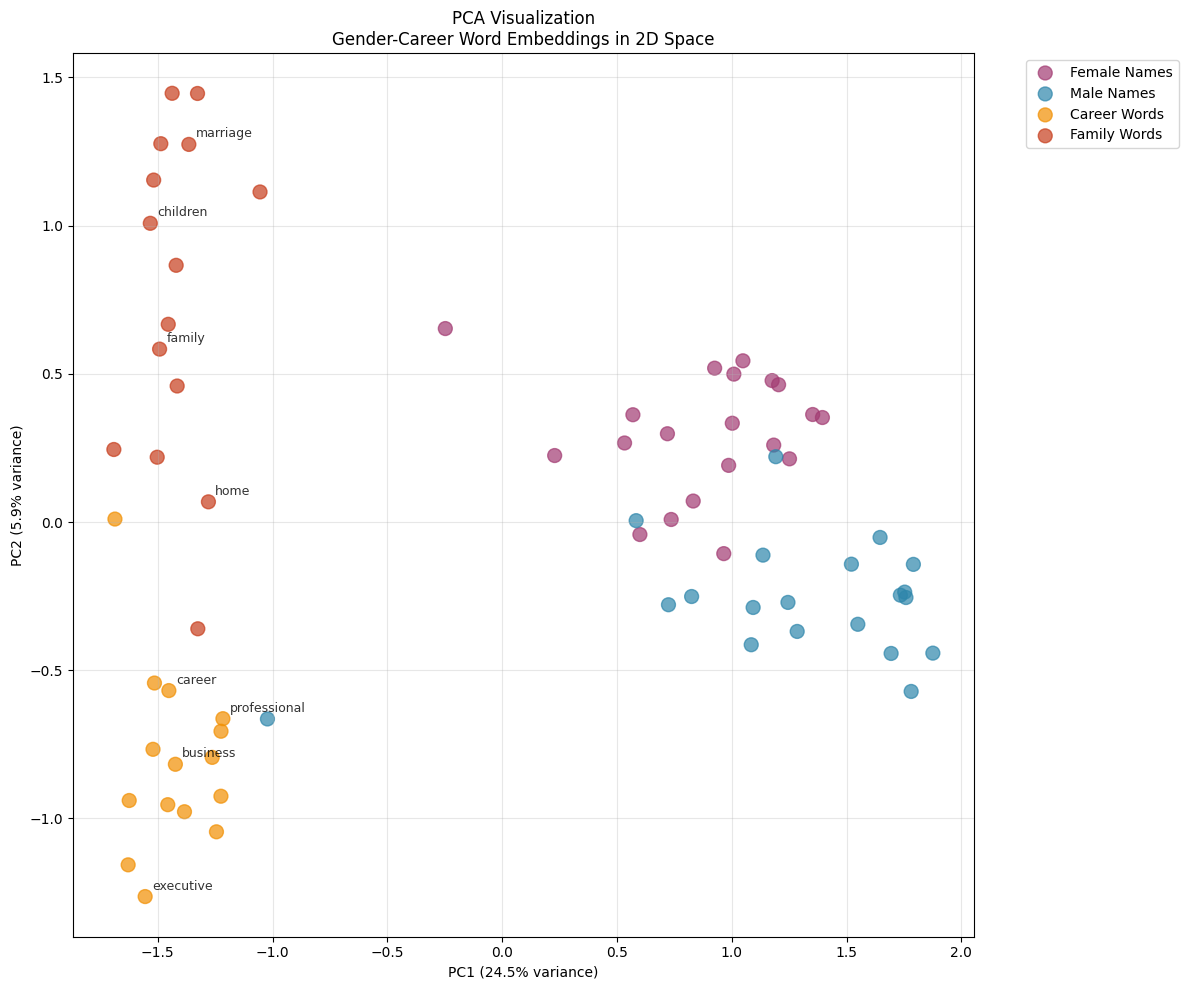

📈 Creating t-SNE visualization...


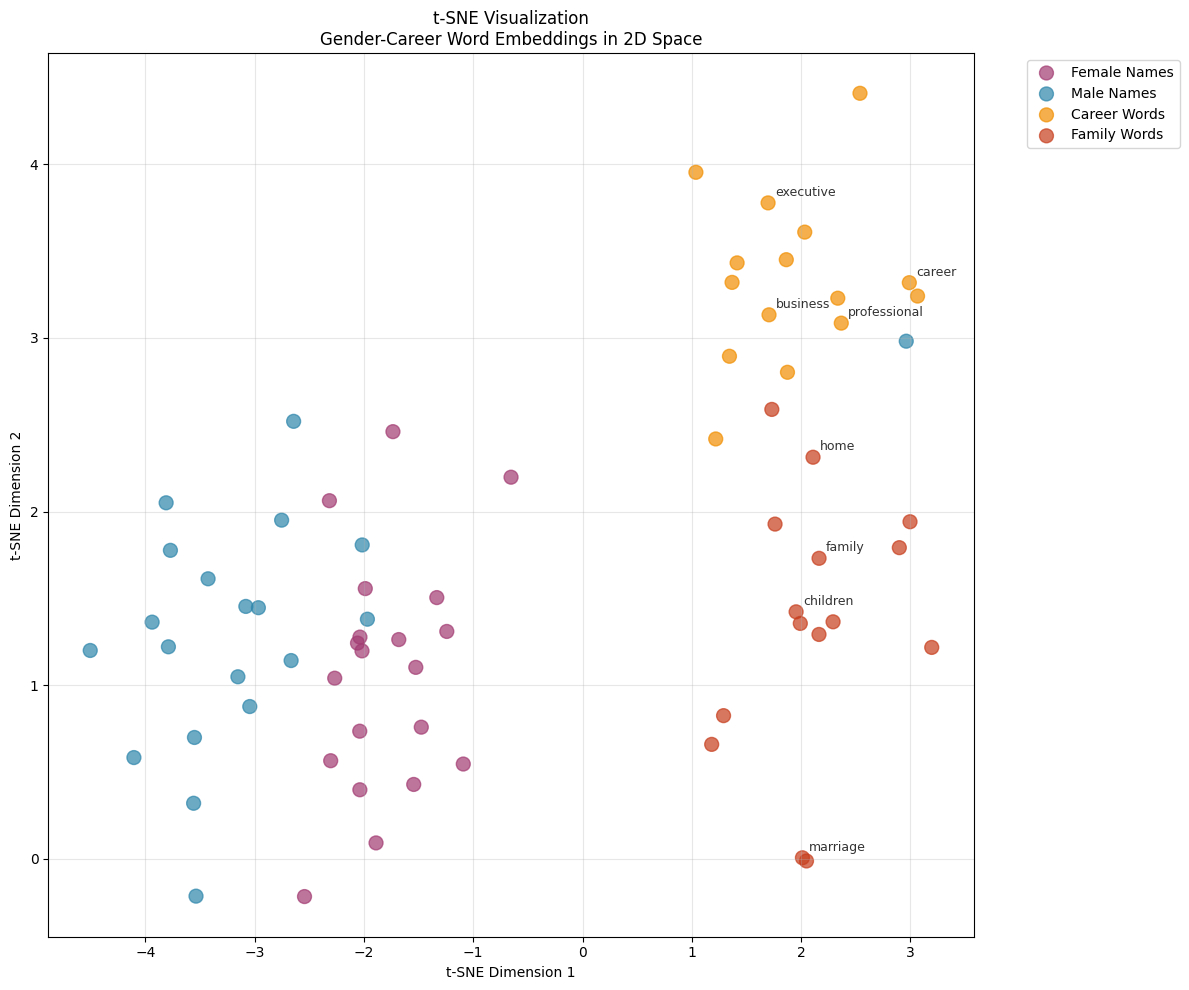

📈 Creating bias vector visualization...


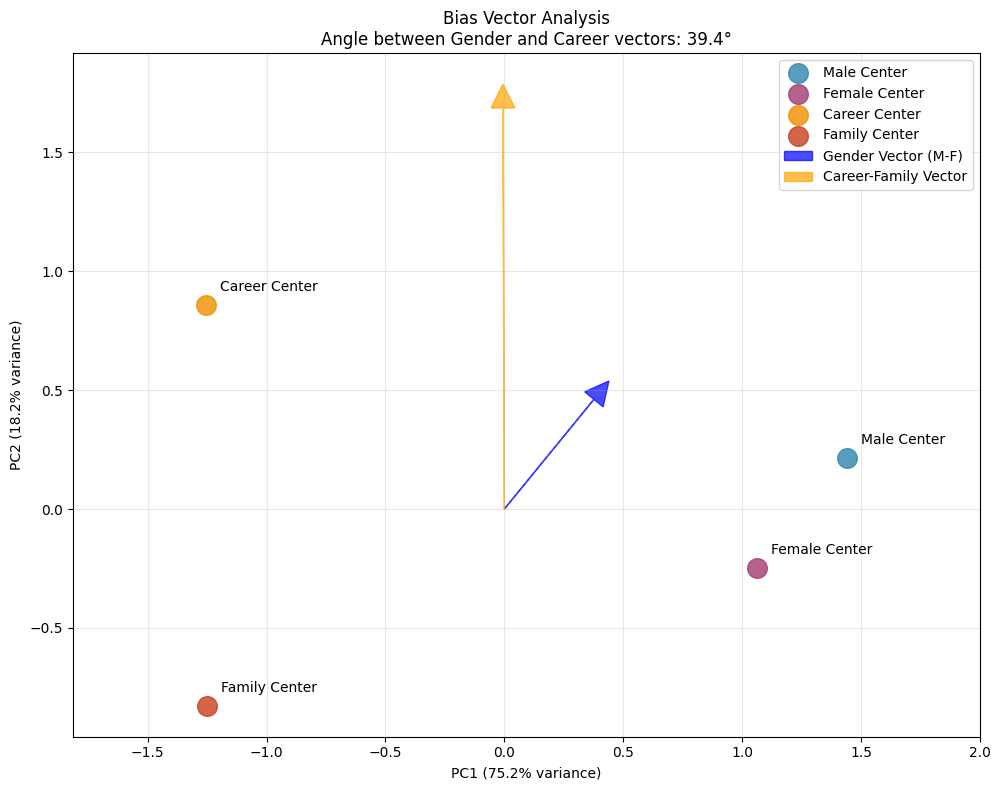

📈 Creating similarity heatmap...


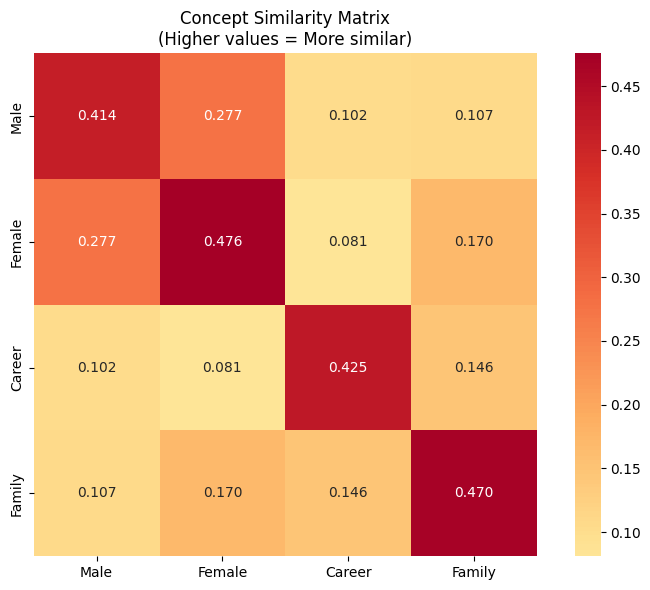

✅ All visualizations completed and saved!

📁 Generated files:
- embeddings_pca_2d.png
- embeddings_tsne_2d.png
- bias_vectors_2d.png
- concept_similarity_heatmap.png


In [8]:
# Add this code to your existing notebook after the WEAT analysis

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

def get_embeddings_for_visualization():
    """Get embeddings for all word lists"""
    embeddings = {}
    labels = {}
    colors = {}
    
    # Define color scheme
    color_map = {
        'male': '#2E86AB',      # Blue
        'female': '#A23B72',    # Pink/Purple  
        'career': '#F18F01',    # Orange
        'family': '#C73E1D'     # Red
    }
    
    # Get male name embeddings
    for word in WEAT_WORDLISTS['gender_career']['target_1']:  # Male names
        emb = get_embedding(word)
        if emb is not None:
            embeddings[word] = emb
            labels[word] = 'Male Names'
            colors[word] = color_map['male']
    
    # Get female name embeddings  
    for word in WEAT_WORDLISTS['gender_career']['target_2']:  # Female names
        emb = get_embedding(word)
        if emb is not None:
            embeddings[word] = emb
            labels[word] = 'Female Names'
            colors[word] = color_map['female']
    
    # Get career word embeddings
    for word in WEAT_WORDLISTS['gender_career']['attribute_1']:  # Career words
        emb = get_embedding(word)
        if emb is not None:
            embeddings[word] = emb
            labels[word] = 'Career Words'
            colors[word] = color_map['career']
    
    # Get family word embeddings
    for word in WEAT_WORDLISTS['gender_career']['attribute_2']:  # Family words
        emb = get_embedding(word)
        if emb is not None:
            embeddings[word] = emb
            labels[word] = 'Family Words'
            colors[word] = color_map['family']
    
    return embeddings, labels, colors

def create_2d_visualization_pca(embeddings, labels, colors, title="PCA Visualization"):
    """Create 2D visualization using PCA"""
    # Prepare data
    words = list(embeddings.keys())
    vectors = np.array([embeddings[word] for word in words])
    
    # Apply PCA
    pca = PCA(n_components=2, random_state=42)
    vectors_2d = pca.fit_transform(vectors)
    
    # Create plot
    plt.figure(figsize=(12, 10))
    
    # Plot points by category
    categories = set(labels.values())
    for category in categories:
        category_words = [w for w in words if labels[w] == category]
        category_vectors = np.array([vectors_2d[words.index(w)] for w in category_words])
        category_colors = [colors[w] for w in category_words]
        
        plt.scatter(category_vectors[:, 0], category_vectors[:, 1], 
                   c=category_colors, label=category, alpha=0.7, s=100)
    
    # Add word labels for some key words
    key_words = ['man', 'woman', 'career', 'family', 'business', 'home', 
                 'professional', 'children', 'executive', 'marriage']
    for word in key_words:
        if word in words:
            idx = words.index(word)
            plt.annotate(word, (vectors_2d[idx, 0], vectors_2d[idx, 1]), 
                        xytext=(5, 5), textcoords='offset points', 
                        fontsize=9, alpha=0.8)
    
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
    plt.title(f'{title}\nGender-Career Word Embeddings in 2D Space')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    return plt.gcf()

def create_2d_visualization_tsne(embeddings, labels, colors, title="t-SNE Visualization"):
    """Create 2D visualization using t-SNE"""
    # Prepare data
    words = list(embeddings.keys())
    vectors = np.array([embeddings[word] for word in words])
    
    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(words)-1))
    vectors_2d = tsne.fit_transform(vectors)
    
    # Create plot
    plt.figure(figsize=(12, 10))
    
    # Plot points by category
    categories = set(labels.values())
    for category in categories:
        category_words = [w for w in words if labels[w] == category]
        category_vectors = np.array([vectors_2d[words.index(w)] for w in category_words])
        category_colors = [colors[w] for w in category_words]
        
        plt.scatter(category_vectors[:, 0], category_vectors[:, 1], 
                   c=category_colors, label=category, alpha=0.7, s=100)
    
    # Add word labels for some key words
    key_words = ['man', 'woman', 'career', 'family', 'business', 'home',
                 'professional', 'children', 'executive', 'marriage']
    for word in key_words:
        if word in words:
            idx = words.index(word)
            plt.annotate(word, (vectors_2d[idx, 0], vectors_2d[idx, 1]), 
                        xytext=(5, 5), textcoords='offset points', 
                        fontsize=9, alpha=0.8)
    
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.title(f'{title}\nGender-Career Word Embeddings in 2D Space')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    return plt.gcf()

def create_bias_vector_visualization(embeddings):
    """Create visualization showing bias vectors"""
    # Calculate concept centers
    male_names = [w for w in embeddings.keys() if w in WEAT_WORDLISTS['gender_career']['target_1']]
    female_names = [w for w in embeddings.keys() if w in WEAT_WORDLISTS['gender_career']['target_2']]
    career_words = [w for w in embeddings.keys() if w in WEAT_WORDLISTS['gender_career']['attribute_1']]
    family_words = [w for w in embeddings.keys() if w in WEAT_WORDLISTS['gender_career']['attribute_2']]
    
    # Calculate centroids
    male_center = np.mean([embeddings[w] for w in male_names], axis=0)
    female_center = np.mean([embeddings[w] for w in female_names], axis=0)
    career_center = np.mean([embeddings[w] for w in career_words], axis=0)
    family_center = np.mean([embeddings[w] for w in family_words], axis=0)
    
    # Create gender and career/family vectors
    gender_vector = male_center - female_center  # Male - Female
    career_family_vector = career_center - family_center  # Career - Family
    
    # Project onto 2D using PCA
    all_vectors = np.array([male_center, female_center, career_center, family_center])
    pca = PCA(n_components=2, random_state=42)
    centers_2d = pca.fit_transform(all_vectors)
    
    # Transform vectors to 2D
    gender_vec_2d = pca.transform([male_center])[0] - pca.transform([female_center])[0]
    career_vec_2d = pca.transform([career_center])[0] - pca.transform([family_center])[0]
    
    # Create plot
    plt.figure(figsize=(10, 8))
    
    # Plot centroids
    labels = ['Male Center', 'Female Center', 'Career Center', 'Family Center']
    colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']
    
    for i, (label, color) in enumerate(zip(labels, colors)):
        plt.scatter(centers_2d[i, 0], centers_2d[i, 1], c=color, s=200, alpha=0.8, label=label)
        plt.annotate(label, (centers_2d[i, 0], centers_2d[i, 1]), 
                    xytext=(10, 10), textcoords='offset points', fontsize=10)
    
    # Draw vectors from origin
    origin = np.array([0, 0])
    plt.arrow(0, 0, gender_vec_2d[0], gender_vec_2d[1], 
             head_width=0.1, head_length=0.1, fc='blue', ec='blue', alpha=0.7, label='Gender Vector (M-F)')
    plt.arrow(0, 0, career_vec_2d[0], career_vec_2d[1], 
             head_width=0.1, head_length=0.1, fc='orange', ec='orange', alpha=0.7, label='Career-Family Vector')
    
    # Calculate and show angle between vectors
    cos_angle = np.dot(gender_vec_2d, career_vec_2d) / (np.linalg.norm(gender_vec_2d) * np.linalg.norm(career_vec_2d))
    angle_degrees = np.degrees(np.arccos(np.clip(cos_angle, -1.0, 1.0)))
    
    plt.title(f'Bias Vector Analysis\nAngle between Gender and Career vectors: {angle_degrees:.1f}°')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.tight_layout()
    return plt.gcf()

def create_similarity_heatmap_2d():
    """Create a 2D heatmap showing similarities between concepts"""
    # Define representative words
    concepts = {
        'Male': ['man', 'he', 'his', 'john', 'james'],
        'Female': ['woman', 'she', 'her', 'mary', 'patricia'], 
        'Career': ['career', 'professional', 'business', 'office'],
        'Family': ['family', 'home', 'children', 'marriage']
    }
    
    # Calculate average similarities
    concept_names = list(concepts.keys())
    similarity_matrix = np.zeros((len(concept_names), len(concept_names)))
    
    for i, concept1 in enumerate(concept_names):
        for j, concept2 in enumerate(concept_names):
            similarities = []
            for word1 in concepts[concept1]:
                emb1 = get_embedding(word1)
                if emb1 is not None:
                    for word2 in concepts[concept2]:
                        emb2 = get_embedding(word2)
                        if emb2 is not None:
                            sim = cosine_similarity(emb1, emb2)
                            similarities.append(sim)
            
            if similarities:
                similarity_matrix[i, j] = np.mean(similarities)
    
    # Create heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(similarity_matrix, 
                xticklabels=concept_names, 
                yticklabels=concept_names,
                annot=True, fmt='.3f', 
                cmap='RdYlBu_r',
                center=0,
                square=True)
    plt.title('Concept Similarity Matrix\n(Higher values = More similar)')
    plt.tight_layout()
    return plt.gcf()

# Run all visualizations
print("🔍 Creating 2D visualizations of gender-career bias...")

# Get embeddings for visualization
embeddings, labels, colors = get_embeddings_for_visualization()
print(f"📊 Loaded {len(embeddings)} word embeddings for visualization")

# Create PCA visualization
print("📈 Creating PCA visualization...")
fig1 = create_2d_visualization_pca(embeddings, labels, colors)
plt.savefig('embeddings_pca_2d.png', dpi=300, bbox_inches='tight')
plt.show()

# Create t-SNE visualization  
print("📈 Creating t-SNE visualization...")
fig2 = create_2d_visualization_tsne(embeddings, labels, colors)
plt.savefig('embeddings_tsne_2d.png', dpi=300, bbox_inches='tight')
plt.show()

# Create bias vector visualization
print("📈 Creating bias vector visualization...")
fig3 = create_bias_vector_visualization(embeddings)
plt.savefig('bias_vectors_2d.png', dpi=300, bbox_inches='tight')
plt.show()

# Create similarity heatmap
print("📈 Creating similarity heatmap...")
fig4 = create_similarity_heatmap_2d()
plt.savefig('concept_similarity_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ All visualizations completed and saved!")
print("\n📁 Generated files:")
print("- embeddings_pca_2d.png")
print("- embeddings_tsne_2d.png") 
print("- bias_vectors_2d.png")
print("- concept_similarity_heatmap.png")